In [2]:
import torch
print(torch.cuda.device_count())

1


If the below says 10.2, you will get the `sm_80` CUDA compatibility warning

In [4]:
torch.version.cuda

'11.3'

In [1]:
%cd STEP1.AutoencoderModel/

/scratch4/randalburns/DiffTumor/STEP1.AutoencoderModel


In [12]:
import torch
from vq_gan_3d.model.vqgan import VQGAN
from torchvision import transforms
import nibabel as nib
import numpy as np

# Load the pretrained VQGAN model
vqgan_ckpt = '../STEP2.DiffusionModel/pretrained_models/AutoencoderModel.ckpt'
vqgan_model = VQGAN.load_from_checkpoint(vqgan_ckpt).cuda()
vqgan_model.eval()

# Define a function to encode 3D CT scans using the encoder from VQGAN
def encode_ct_scan(nii_path):
    # Load and preprocess the CT scan
    img = nib.load(nii_path)
    img_data = img.get_fdata()

    # Normalize the image data (adjust as needed)
    # img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))
    img_data = torch.tensor(img_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda()  # Add channel and batch dimensions

    with torch.no_grad():
        encoded_image = vqgan_model.encode(img_data, quantize=False, include_embeddings=True)
        # Normalize the encoded output to match the expected range (-1 to 1)
        # encoded_image = ((encoded_image - vqgan_model.codebook.embeddings.min()) /
                         # (vqgan_model.codebook.embeddings.max() - vqgan_model.codebook.embeddings.min())) * 2.0 - 1.0
    return encoded_image

/scratch4/randalburns/DiffTumor/venv-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch4/randalburns/DiffTumor/venv-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from /scratch4/randalburns/DiffTumor/STEP1.AutoencoderModel/vq_gan_3d/model/cache/vgg.pth


In [6]:
# Define the repository and file path
repo_id = "AbdomenAtlas/AbdomenAtlas1.0Mini"
filename = "BDMAP_00000087/ct.nii.gz"

download_folder = "/home/alubonj1/scr4_randalburns/DiffTumor"

### Optional - download more data files from 🤗

In [3]:
import os
from huggingface_hub import login
# Need a HF token. Set it as an OS env var and don't commit it to git!

from huggingface_hub import hf_hub_download

# token = os.getenv("HF_API_TOKEN")
login()#token=token)

In [ ]:
# Download the file
downloaded_file = hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset", local_dir=download_folder)

print(f"File downloaded to: {downloaded_file}")

File downloaded to: /home/alubonj1/scr4_randalburns/DiffTumor/BDMAP_00000087/ct.nii.gz


### Encode Images

In [13]:
import os

# Step 3: Use the function to encode a new CT image
nii_path = os.path.join(download_folder, filename)
encoded_image = encode_ct_scan(nii_path)
print(encoded_image.shape)  # Inspect the shape of the encoded image

torch.Size([1, 8, 113, 81, 25])


In [14]:
enc_img = encoded_image.squeeze()
print(enc_img.shape)

torch.Size([8, 113, 81, 25])


In [8]:
img = nib.load(nii_path)
img.shape

(452, 324, 103)

The above shape should match what you see in ITK-Snap

In [13]:
452*324*103

15084144

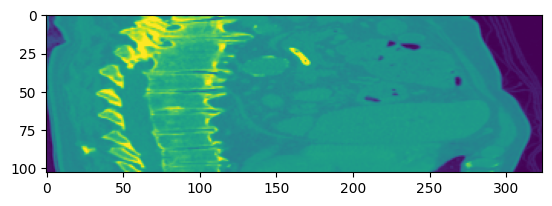

In [12]:
from matplotlib import pyplot as plt

plt.imshow(img.get_fdata()[220].T)